## Project overview
With the rapid rise of AI-generated content, phishing emails have become more sophisticated and harder to detect through traditional methods. Attackers now craft deceptive messages that closely mimic legitimate communication, putting individuals and organizations at risk of data theft, financial fraud, and identity compromise. This project aims to address the growing threat by developing an intelligent phishing email detection system using BERT, a powerful transformer-based language model. By analyzing the textual content of emails, our model learns to distinguish between phishing and legitimate messages with high accuracy, helping to automate and enhance email security on a large scale.

In [4]:
# Installing and verifying core dependencies
%pip install --upgrade pip
%pip install pandas torch torchvision torchaudio --prefer-binary
%pip uninstall -y pyarrow datasets
%pip install "pyarrow>=15.0.0"
%pip install "datasets>=2.18.0"
%pip install "accelerate>=0.26.0"
%pip install transformers scikit-learn seaborn matplotlib nltk wordcloud
%pip install kagglehub


import sys
import pandas as pd
import torch


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: pyarrow 22.0.0
Uninstalling pyarrow-22.0.0:
  Successfully uninstalled pyarrow-22.0.0
Found existing installation: pyarrow 22.0.0
Uninstalling pyarrow-22.0.0:
  Successfully uninstalled pyarrow-22.0.0
Found existing installation: datasets 4.3.0
Uninstalling datasets-4.3.0:
  Successfully uninstalled datasets-4.3.0
Found existing installation: datasets 4.3.0
Uninstalling datasets-4.3.0:
  Successfully uninstalled datasets-4.3.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyarrow-22.0.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (3.2 kB)
Using cached pyarrow-22.0.0-cp313-cp313-macosx_12_0_arm64.whl 

In [5]:

import pandas as pd
import re
import torch

#libraries for data explore
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for Model training and evaluation
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [6]:
# Load dataset from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

# Load the CSV file
import os
csv_file = os.path.join(path, "Phishing_Email.csv")
df = pd.read_csv(csv_file)

print("First 5 records:")
print(df.head())
print("\nDataset shape:", df.shape)

Path to dataset files: /Users/tasneemzaman/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1
First 5 records:
                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0

Dataset shape: (82486, 2)
First 5 records:
                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0

Dataset shape: (82486, 2)


In [7]:
# Randomly sample 2500 rows from the full dataset
df = df.sample(n=2500, random_state=42).reset_index(drop=True)

print(df.head())

                                       text_combined  label
0  endangered languages workshop foundation endan...      0
1  claretta claretta_bordersfusemailcom cialis wo...      1
2  roger upole schkeramsncom kyle rickey wrote im...      0
3  barclays customer service testlightworldcojp d...      1
4  gmm 09 nov 2001 please find attached global ma...      0


## Preprocess the Data

- **Remove null**
- **Lowercasing** : BERT handles case, but lowercase helps traditional models


In [21]:
# Check the actual column names in the dataset
print("Column names:", df.columns.tolist())
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Column names: ['text_combined', 'label']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  2500 non-null   object
 1   label          2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
None

First few rows:
                                       text_combined  label
0  originations schedules louise please let know ...      0
1  lctitguzgmasseyacnz message sent behalf colleg...      0
2  nicholas kelly nicholasactinolitesanderstragic...      1
3  dislike slow internet speeds hey visioson hpp ...      1
4  california capacity report week 2 12 2 16 tran...      0


# The following preprocessing steps are intentionally skipped to preserve
# key phishing indicators present in the original text data. Each decision
# is justified below:

1. Remove URLs:
   - URLs are strong phishing indicators (e.g., fake login links).
   - Keeping them helps the model detect malicious patterns in domain names.

2. Remove Special Characters:
   - Symbols like @, $, and ! are commonly used in phishing tactics.
   - Retaining them ensures these cues remain available for analysis.

3. Remove Punctuation:
   - Punctuation can appear in deceptive formatting or embedded within URLs.
   - We keep punctuation to preserve structural clues in the text.

4. Remove Numbers:
   - Numbers (e.g., fake invoice IDs, OTPs, account numbers) often appear in phishing messages.
   - These may serve as important features, so we do not remove them.

5. Remove Stopwords:
   - Even common words can carry phishing intent when used in specific contexts (e.g., “verify your account”).
   - Therefore, stopwords are retained.

6. Convert to Lowercase:
   - Capitalization can indicate urgency or deception (e.g., “URGENT”, “ACTION REQUIRED”).
   - We preserve the original casing to maintain these signals.

7. Stemming / Lemmatization:
   - Reducing words to their root form may remove stylistic or grammatical cues.
   - We keep original word forms to capture subtle differences in phishing language.

8. Remove HTML Tags:
   - Some phishing emails use HTML tricks or hidden elements.
   - Keeping the HTML structure allows the model to learn from such artifacts.

9. Spelling Correction:
   - Misspellings are often deliberate in phishing attempts (to bypass filters).
   - We avoid correcting spelling errors to retain their analytical value.


In [8]:
# Remove nulls
df.dropna(inplace=True)

df['label'] = df['label'].astype(int)

# Lowercasing only
def clean_text(text):
    return text.lower()

df['text'] = df['text_combined'].apply(clean_text)

# Drop the original column and keep the cleaned 'text' column
df.drop('text_combined', axis=1, inplace=True)

print("Preprocessing complete!")
print("Columns after preprocessing:", df.columns.tolist())

Preprocessing complete!
Columns after preprocessing: ['label', 'text']


In [23]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2500 non-null   int64 
 1   text    2500 non-null   object
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
None


In [24]:
df.shape

(2500, 2)

In [25]:
df.tail()

,label,text
2495,1,corporate identity business corporate image sa...
2496,0,wild goose open season package expansion firm ...
2497,0,adam l beberg bebergmithralcom sun 1 sep 2002 ...
2498,1,gain 3 full inches length rated 1 penis enlarg...
2499,0,yen outlook vince followup meeting david port ...


# Explore the dataset

#### Plot Class Distribution

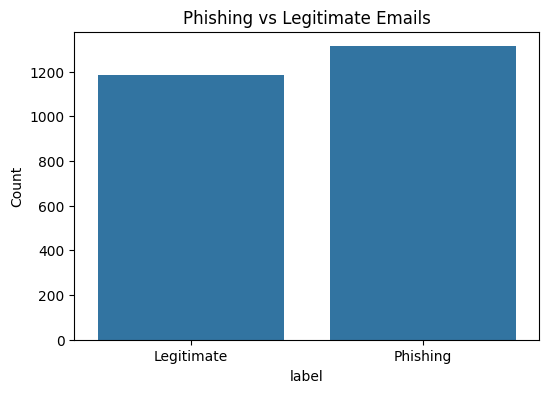

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label') # counts the number of occurrences of each unique value in a column
plt.title('Phishing vs Legitimate Emails')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Count')
plt.show()


#### Email/Text special character Length Distribution by Class
This graph is a boxplot comparing the number of special characters used in legitimate vs phishing emails.

Special characters: ! @ # $ % ^ & * ( ) _ + = { } [ ] : ; " ' < > / ? , . ~ etc.


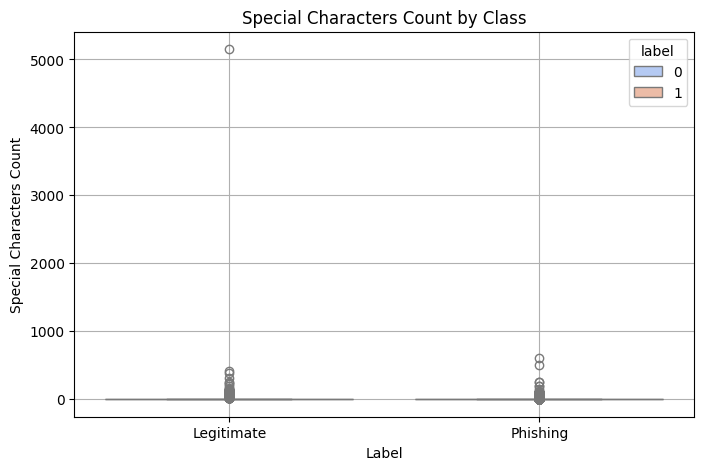

In [27]:
df['special_chars'] = df['text'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='special_chars', data=df, hue='label', palette='coolwarm', dodge=False)

plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.title('Special Characters Count by Class')
plt.xlabel('Label')
plt.ylabel('Special Characters Count')
plt.grid(True)
plt.show()


#### Most Common Words

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>


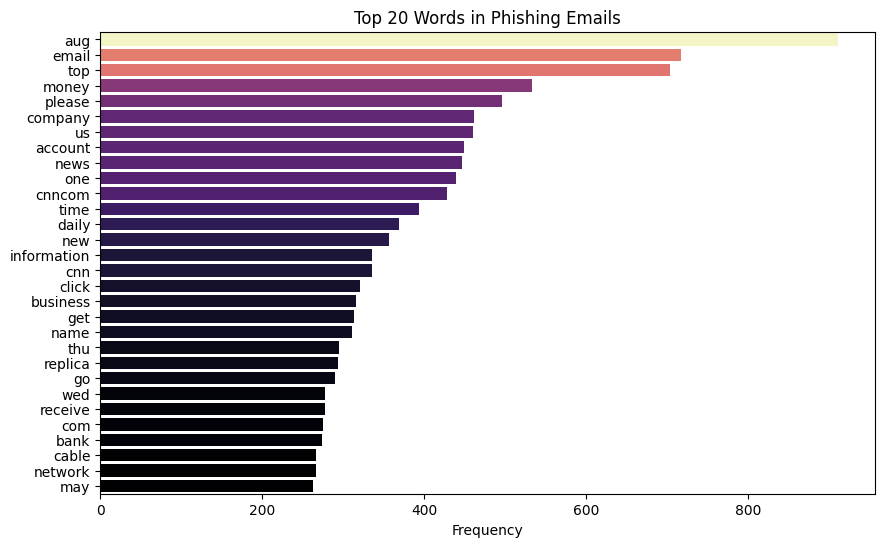

In [28]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))  #e.g., "the", "is", "and"

# Combine all phishing emails: Joins all texts into one string → converts to lowercase → splits into words
phishing_words = ' '.join(df[df['label']==1]['text']).lower().split() #Selects only phishing emails (where label == 1)

filtered_words = [word for word in phishing_words if word.isalpha() and word not in stop_words] #Alphabetic words (removes numbers, punctuation)

word_freq = Counter(filtered_words).most_common(30)

# Barplot of top words
words, counts = zip(*word_freq)  #Unpacks the 20 most common word–count pairs into two separate lists: words and counts
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words),hue =list(counts), palette='magma',legend=False)
plt.title('Top 20 Words in Phishing Emails')
plt.xlabel('Frequency')
plt.show()



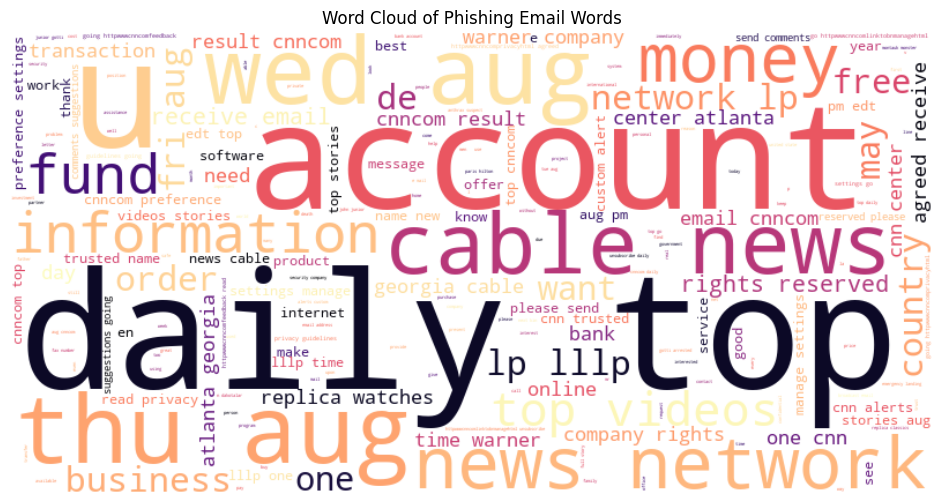

In [30]:
from wordcloud import WordCloud

# Join all filtered phishing words into a single string
wordcloud_text = ' '.join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing Email Words')
plt.show()


 ### Split the Dataset in training , validation and test

In [9]:
from sklearn.model_selection import train_test_split

# 1. First, split out 20% test data

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label'])

# 2. Then split remaining 80% into 70% train and 10% val

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.125,  # 10% of total = 12.5% of the remaining 80%
    random_state=42, stratify=train_val_labels
)


#### Tokenization using BERT Tokenizer

These encodings are the tokenized versions of your input texts, structured in a way that BERT can understand

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


In [35]:
print(train_encodings['input_ids'][0])          # View input IDs of the first text
print(train_encodings['attention_mask'][0]) 

[101, 1043, 3948, 6335, 21030, 2102, 3501, 17560, 9541, 9006, 1050, 2078, 2509, 15756, 6125, 19939, 2075, 2971, 2294, 28332, 2581, 19939, 2075, 2971, 15756, 6125, 15078, 4454, 4725, 2318, 3531, 3942, 1050, 2078, 2509, 4037, 8299, 2860, 2860, 7962, 11236, 2389, 29278, 19281, 16643, 3070, 9006, 22327, 22753, 9006, 8128, 11100, 19939, 2275, 2340, 11118, 2051, 2186, 14125, 2825, 2478, 4725, 15078, 4454, 8335, 16134, 3246, 16157, 5082, 19518, 15756, 6125, 19939, 2075, 4487, 11393, 19269, 3716, 2190, 6078, 2971, 3834, 5682, 3569, 3946, 21871, 2248, 2820, 19939, 2545, 2462, 2546, 4725, 17547, 2971, 2330, 4725, 15078, 4454, 4297, 2140, 5438, 29278, 7652, 28667, 29264, 15756, 6125, 18001, 16014, 5668, 3247, 26237, 24403, 2015, 2490, 9207, 26237, 8893, 8107, 4385, 2109, 3361, 19939, 2075, 7778, 17547, 2051, 2186, 4106, 4772, 3463, 3463, 3591, 2536, 9281, 2289, 12040, 3436, 20932, 4778, 5589, 2824, 2003, 2546, 2692, 2581, 2047, 2259, 1045, 3501, 2278, 10695, 2692, 2581, 10108, 14223, 1040, 10020,

#### Convert to HuggingFace Dataset

A custom PyTorch dataset class for handling tokenized email text data and labels.

- **Inherits**: `torch.utils.data.Dataset`
- **Purpose**: Feeds input to Hugging Face `Trainer` in a structured format.

#### Methods:
- `__init__(self, encodings, labels)`
  - Stores tokenized input data (`encodings`) and labels.
- `__getitem__(self, idx)`
  - Returns the input tensors and label for a specific index.
  - Example output:
    ```python
    {
      'input_ids': tensor(...),
      'attention_mask': tensor(...),
      'labels': tensor(...)
    }
    ```
- `__len__(self)`
  - Returns the total number of samples.
 
    
 
#### Data input format for bert
- input_ids: Token IDs representing the input text.

- attention_mask: Binary mask to distinguish real tokens (1) from padding (0).

- labels: True class values used for supervised learning.

- [CLS]: Special token added at the start of input for classification tasks.

- [SEP]: Separator token marking the end of a sentence or segment.



In [11]:
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)


#### Load Pretrained BERT for Classification

In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Evaluation Metrics

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


#### Training Arguments

`TrainingArguments` is a configuration class that defines how your model should be trained. You pass it key training parameters such as:

- `output_dir`: Where to save model checkpoints.
- `learning_rate`: Controls how fast the model learns.
- `num_train_epochs`: Number of complete passes through the training data.
- `evaluation_strategy`: When to run validation (e.g., `"epoch"` means after every epoch).
- `per_device_train_batch_size`: Batch size per GPU/CPU device during training.
- `logging_dir`: Directory to store training logs.

It does **not** train the model — it only stores training settings that the `Trainer` will use.



In [14]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # ← Reduced from 32 to 8
    per_device_eval_batch_size=8,    # ← Reduced from 32 to 8
    num_train_epochs=2,
    weight_decay=0.01,
    optim="adamw_torch",
    logging_dir='./logs',
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=4    # ← Simulates batch size of 32
)

#### Trainer




`Trainer` is the training engine provided by Hugging Face. It handles the full model training lifecycle. Specifically, it:

- Loads and trains your model.
- Handles batching, shuffling, and tokenization.
- Trains the model using PyTorch under the hood.
- Evaluates the model on your `eval_dataset`.
- Uses the settings defined in `TrainingArguments`.
- Automatically supports training on GPU or TPU if available.

`Trainer` simplifies the process so you don’t need to manually write training loops, backpropagation, or optimizer logic.

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/var/folders/pt/nwd6nb4525gb_2_751vz2ngc0000gn/T/ipykernel_15742/3673888053.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Train the BERT Model

The `trainer.train()` method is the command that **starts the training process** using the configuration and datasets you’ve defined with Hugging Face’s `Trainer` class.

It does the following:

- Loads the `train_dataset` and batches the data.
- Feeds each batch through the model.
- Computes the loss and performs backpropagation to update model weights.
- Evaluates the model on the `eval_dataset` if `evaluation_strategy` is set (e.g., `"epoch"`).
- Saves checkpoints if `save_strategy` is configured.
- Logs training metrics (loss, accuracy, etc.) if `logging_dir` is specified.

##### What It Uses Internally:
- Model defined in `Trainer(model=...)`
- Training configuration from `TrainingArguments`
- Tokenizer and data collator for handling padding and batching
- Evaluation function if `compute_metrics` is provided

##### Output:
After running `trainer.train()`, the model will be:
- Trained on your training data
- Optionally validated each epoch
- Saved to the directory specified in `output_dir`


In [16]:
trainer.train()

/Users/tasneemzaman/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.387200,0.162023,0.956000,0.956522,0.991803,0.923664
2,0.118100,0.136038,0.956000,0.956522,0.991803,0.923664


/Users/tasneemzaman/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=110, training_loss=0.2526278712532737, metrics={'train_runtime': 908.6453, 'train_samples_per_second': 3.852, 'train_steps_per_second': 0.121, 'total_flos': 920888693760000.0, 'train_loss': 0.2526278712532737, 'epoch': 2.0})

## Plot Accuracy and Loss vs Epoch

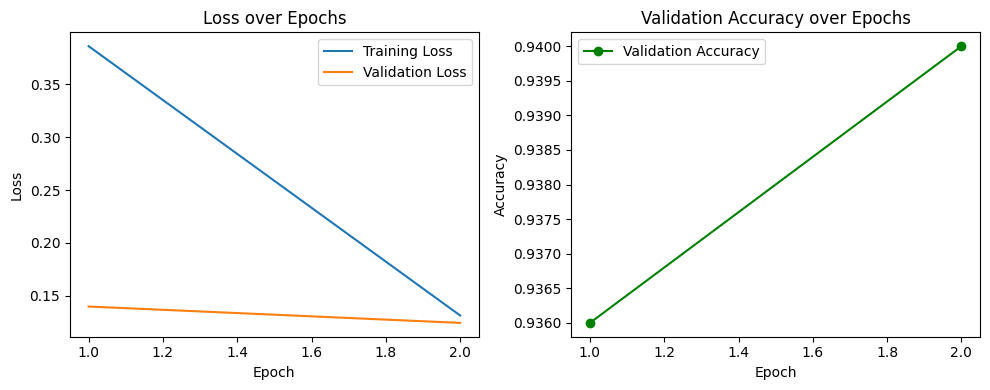

In [42]:
import matplotlib.pyplot as plt

# Extract logs
log_history = trainer.state.log_history

# Gather data
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_acc  = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
epochs = list(range(1, len(eval_loss)+1))

# Plot loss
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, marker='o', color='green', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


## Save the Final Model & Tokenizer

In [17]:
# Save model and tokenizer
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json')

In [44]:
from transformers import BertForSequenceClassification, BertTokenizer
model = BertForSequenceClassification.from_pretrained("./final_model")
tokenizer = BertTokenizer.from_pretrained("./final_model")


### Test the model

##### Tokenize test data

In [45]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

#### Convert to PyTorch Dataset

In [46]:
test_dataset = EmailDataset(test_encodings, test_labels)

#### Evaluate Model on Test Set

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run predictions on the test set
test_results = trainer.predict(test_dataset)

# Extract predicted class labels
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_labels  # Make sure test_labels is a list of integers

# Print all core metrics
print("Final Test Evaluation Metrics:\n")
print("Accuracy       :", accuracy_score(y_true, y_pred))
print("Precision      :", precision_score(y_true, y_pred))
print("Recall         :", recall_score(y_true, y_pred))
print("F1 Score       :", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"]))



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Final Test Evaluation Metrics:

Accuracy       : 0.95
Precision      : 0.968503937007874
Recall         : 0.935361216730038
F1 Score       : 0.9516441005802708

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.93      0.97      0.95       237
    Phishing       0.97      0.94      0.95       263

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



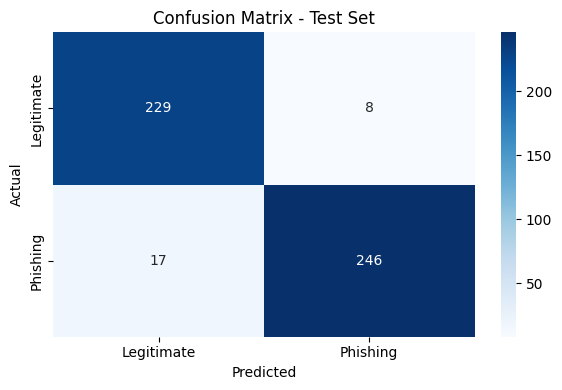

In [48]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import classification_report

y_pred = test_results.predictions.argmax(axis=1)
print(classification_report(test_labels, y_pred, target_names=["Legitimate", "Phishing"]))


              precision    recall  f1-score   support

  Legitimate       0.93      0.97      0.95       237
    Phishing       0.97      0.94      0.95       263

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



## 🎯 Interactive Email Classifier

Use the cell below to test any email and see if it's phishing or legitimate.

**How to use:**
1. Run the cell below
2. Paste your email text (can be multiple lines)
3. Press Enter on an empty line to get the prediction

**Example phishing email you can test:**
```
URGENT: Your account has been compromised!
Click here immediately to verify your identity: http://suspicious-link.com
If you don't act within 24 hours, your account will be suspended.
```

**Example legitimate email:**
```
Hi team, our weekly meeting is scheduled for tomorrow at 2 PM.
Please review the attached agenda beforehand.
Looking forward to seeing everyone there!
```


In [18]:
# Robust interactive predictor: will load tokenizer/model if not already defined
import os
import torch

# Helper: ensure model and tokenizer are available
def ensure_model_and_tokenizer(model_dir='./final_model'):
    global model, tokenizer
    try:
        model  # noqa: F821
        tokenizer  # noqa: F821
        return
    except NameError:
        pass

    from transformers import BertForSequenceClassification, BertTokenizer

    if os.path.isdir(model_dir) and os.listdir(model_dir):
        print(f"Loading saved model and tokenizer from '{model_dir}'...")
        model = BertForSequenceClassification.from_pretrained(model_dir)
        tokenizer = BertTokenizer.from_pretrained(model_dir)
    else:
        print("Saved model not found at './final_model'. Loading 'bert-base-uncased' from Hugging Face hub (internet required)...")
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load or verify model/tokenizer
try:
    ensure_model_and_tokenizer()
except Exception as e:
    print('Error loading model/tokenizer:', e)
    raise

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)
model.eval()
print(f"Model loaded on device: {device}")

# Use existing `email_text` variable if it was set previously and non-empty, otherwise prompt user
user_text = None
if 'email_text' in globals() and isinstance(email_text, str) and email_text.strip():
    user_text = email_text.strip()
else:
    print("\nPaste the full email text below. Finish by pressing Enter on an empty line:")
    lines = []
    while True:
        try:
            line = input()
        except EOFError:
            break
        if line == "":
            break
        lines.append(line)
    user_text = "\n".join(lines).strip()

if not user_text:
    print("No email text provided. Please run the cell again and paste an email.")
else:
    # Minimal preprocessing consistent with notebook
    text = user_text.lower()

    # Tokenize
    enc = tokenizer(text, truncation=True, padding=True, return_tensors='pt')

    # Move tensors to device
    enc = {k: v.to(device) for k, v in enc.items()}

    # Predict
    try:
        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).squeeze().tolist()
            # Ensure probs is a sequence of length 2
            if isinstance(probs, float):
                probs = [1 - probs, probs]
            pred = int(torch.argmax(logits, dim=1).item())

        label = "Phishing" if pred == 1 else "Legitimate"
        print(f"\n{'='*50}")
        print(f"Prediction: {label}")
        print(f"{'='*50}")
        print(f"Confidence:")
        print(f"  • Legitimate: {probs[0]*100:.1f}%")
        print(f"  • Phishing:   {probs[1]*100:.1f}%")
        print(f"{'='*50}")
    except Exception as e:
        print('Error during prediction:', e)
        raise


Model loaded on device: mps

Prediction: Legitimate
Confidence:
  • Legitimate: 68.5%
  • Phishing:   31.5%

Prediction: Legitimate
Confidence:
  • Legitimate: 68.5%
  • Phishing:   31.5%
